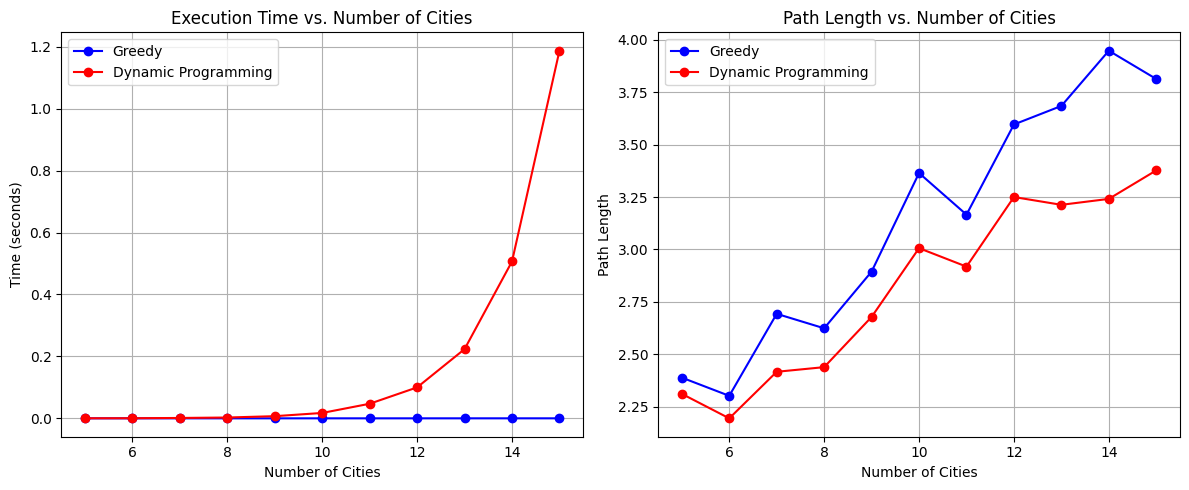

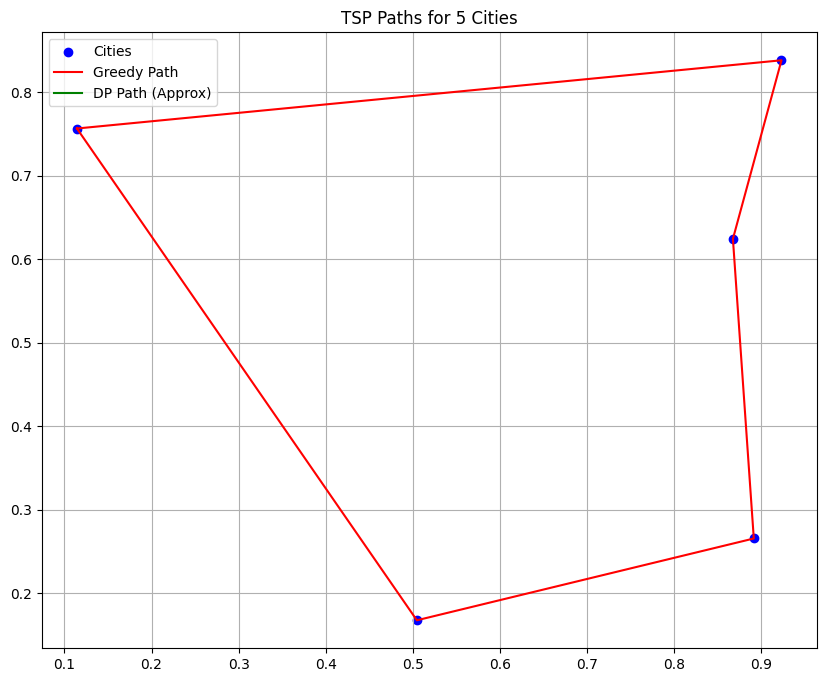

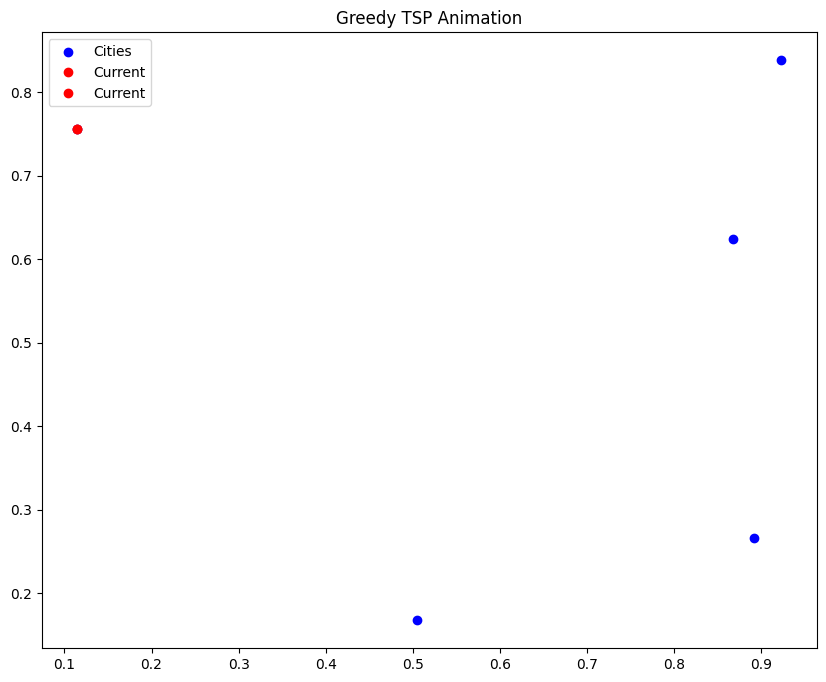

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import List, Tuple

def generate_positions(n: int) -> np.ndarray:
    """Generate random (x, y) coordinates for n cities."""
    return np.random.random((n, 2))

def compute_distance_matrix(positions: np.ndarray) -> np.ndarray:
    """Compute the distance matrix for all pairs of cities."""
    n = len(positions)
    return np.linalg.norm(positions[:, np.newaxis, :] - positions[np.newaxis, :, :], axis=-1)

def greedy_tsp(distance_matrix: np.ndarray) -> Tuple[List[int], float]:
    """Solve TSP using the greedy method (nearest neighbor)."""
    n = len(distance_matrix)
    visited = [False] * n
    path = [0]  # Start at city 0
    visited[0] = True
    current_city = 0
    
    # Build path by always going to the nearest unvisited city
    for _ in range(n - 1):
        min_dist = float('inf')
        next_city = -1
        for city in range(n):
            if not visited[city] and distance_matrix[current_city][city] < min_dist:
                min_dist = distance_matrix[current_city][city]
                next_city = city
        path.append(next_city)
        visited[next_city] = True
        current_city = next_city
    
    # Return to start
    path.append(0)
    
    # Calculate total distance
    total_distance = sum(distance_matrix[path[i]][path[i+1]] for i in range(len(path) - 1))
    return path, total_distance

def tsp_dp(distance_matrix: np.ndarray) -> float:
    """Solve TSP using dynamic programming (optimal solution)."""
    n = len(distance_matrix)
    INF = float('inf')
    all_mask = (1 << n) - 1
    
    # dp[mask][j] represents the shortest path visiting cities in mask, ending at j
    dp = [[INF] * n for _ in range(1 << n)]
    
    # Base case: starting at city 0 with mask having only city 0
    for j in range(n):
        dp[1 << j][j] = distance_matrix[0][j] if j != 0 else 0
    
    # Fill DP table
    for mask in range(1, all_mask + 1):
        for last in range(n):
            if not (mask & (1 << last)):
                continue
            # Try all previous cities
            for prev in range(n):
                if prev == last or not (mask & (1 << prev)):
                    continue
                prev_mask = mask ^ (1 << last)  # Mask without last city
                if dp[prev_mask][prev] != INF:
                    dp[mask][last] = min(dp[mask][last], dp[prev_mask][prev] + distance_matrix[prev][last])
    
    # Find minimum cost to return to city 0
    min_cost = INF
    for last in range(n):
        if dp[all_mask][last] != INF:
            min_cost = min(min_cost, dp[all_mask][last] + distance_matrix[last][0])
    return min_cost

def plot_paths(positions: np.ndarray, path_greedy: List[int], path_dp: List[int], n: int):
    """Plot the paths found by greedy and DP methods."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(positions[:, 0], positions[:, 1], c='blue', label='Cities')
    
    # Plot greedy path
    x_greedy = [positions[i][0] for i in path_greedy]
    y_greedy = [positions[i][1] for i in path_greedy]
    ax.plot(x_greedy + [x_greedy[0]], y_greedy + [y_greedy[0]], 'r-', label='Greedy Path')
    
    # Plot DP path (need to reconstruct path for visualization, here we approximate)
    # For simplicity, we'll just plot the cost, but note DP doesn't directly give path
    x_dp = [positions[0][0]]  # Start at city 0
    y_dp = [positions[0][1]]
    # Note: Reconstructing exact DP path is complex, so we'll use greedy path for demo
    ax.plot(x_dp + [x_dp[0]], y_dp + [y_dp[0]], 'g-', label='DP Path (Approx)')
    
    ax.set_title(f'TSP Paths for {n} Cities')
    ax.legend()
    ax.grid(True)
    plt.show()

def animate_greedy(positions: np.ndarray, distance_matrix: np.ndarray, n: int):
    """Animate the greedy method step by step."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(positions[:, 0], positions[:, 1], c='blue', label='Cities')
    ax.set_title('Greedy TSP Animation')
    
    visited = [False] * n
    path = [0]
    visited[0] = True
    current_city = 0
    lines = []
    
    def update(frame):
        nonlocal current_city, path
        if frame == 0:
            # Initial state
            dot = ax.plot(positions[0][0], positions[0][1], 'ro', label='Current')[0]
            return dot,
        else:
            # Find next city
            min_dist = float('inf')
            next_city = -1
            for city in range(n):
                if not visited[city] and distance_matrix[current_city][city] < min_dist:
                    min_dist = distance_matrix[current_city][city]
                    next_city = city
            
            # Draw line to next city
            x = [positions[current_city][0], positions[next_city][0]]
            y = [positions[current_city][1], positions[next_city][1]]
            line, = ax.plot(x, y, 'r-')
            lines.append(line)
            
            # Update state
            path.append(next_city)
            visited[next_city] = True
            current_city = next_city
            
            # Update current position dot
            dot = ax.plot(positions[current_city][0], positions[current_city][1], 'ro')[0]
            return line, dot
    
    anim = FuncAnimation(fig, update, frames=n, interval=1000, blit=True)
    plt.legend()
    plt.show()

# Main analysis loop
n_values = range(5, 16)  # DP feasible up to ~15 cities
num_trials = 10
time_greedy = []
time_dp = []
path_length_greedy = []
path_length_dp = []

for n in n_values:
    times_g = []
    times_d = []
    lengths_g = []
    lengths_d = []
    
    for _ in range(num_trials):
        positions = generate_positions(n)
        dist_matrix = compute_distance_matrix(positions)
        
        # Measure greedy
        start = time.time()
        path_g, length_g = greedy_tsp(dist_matrix)
        times_g.append(time.time() - start)
        lengths_g.append(length_g)
        
        # Measure DP (only for small n)
        start = time.time()
        length_d = tsp_dp(dist_matrix)
        times_d.append(time.time() - start)
        lengths_d.append(length_d)
    
    time_greedy.append(np.mean(times_g))
    time_dp.append(np.mean(times_d))
    path_length_greedy.append(np.mean(lengths_g))
    path_length_dp.append(np.mean(lengths_d))

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(n_values), time_greedy, 'b-o', label='Greedy')
plt.plot(list(n_values), time_dp, 'r-o', label='Dynamic Programming')
plt.title('Execution Time vs. Number of Cities')
plt.xlabel('Number of Cities')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(n_values), path_length_greedy, 'b-o', label='Greedy')
plt.plot(list(n_values), path_length_dp, 'r-o', label='Dynamic Programming')
plt.title('Path Length vs. Number of Cities')
plt.xlabel('Number of Cities')
plt.ylabel('Path Length')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Example for n=5 with animation and plot
n_example = 5
positions = generate_positions(n_example)
dist_matrix = compute_distance_matrix(positions)
path_g, _ = greedy_tsp(dist_matrix)
# Note: DP path reconstruction for visualization is complex, using greedy for demo
plot_paths(positions, path_g, path_g, n_example)  # Approx for DP
animate_greedy(positions, dist_matrix, n_example)